In [6]:
import tensorflow as tf, numpy as np, google.protobuf as pb
print("TF :", tf.__version__)
print("NP :", np.__version__)
print("PB :", pb.__version__)
print("GPUs:", tf.config.list_physical_devices('GPU'))

TF : 2.10.0
NP : 1.23.5
PB : 3.19.6
GPUs: []


In [1]:
# Imports & directory layout
from pathlib import Path
import hashlib, json, shutil, itertools, gc
from collections import defaultdict
from tqdm import tqdm
from PIL import Image
import itertools, shutil

from imagededup.methods import PHash, DHash, CNN
from imagededup.utils import plot_duplicates

In [2]:
# User‑configurable root
IMAGE_DIR  = Path('E:\DeepLearning\Data\Mika-Pikazo_Full')

# Everything self‑contained under IMAGE_DIR
WORK_DIR   = IMAGE_DIR / '_dedup_meta'
REVIEW_DIR = IMAGE_DIR / '_duplicates_to_review'

for d in (WORK_DIR, REVIEW_DIR):
    d.mkdir(parents=True, exist_ok=True)

print(f"IMAGE_DIR  : {IMAGE_DIR.resolve()}")
print(f"WORK_DIR   : {WORK_DIR.resolve()}")
print(f"REVIEW_DIR : {REVIEW_DIR.resolve()}")

IMAGE_DIR  : E:\DeepLearning\Data\Mika-Pikazo_Full
WORK_DIR   : E:\DeepLearning\Data\Mika-Pikazo_Full\_dedup_meta
REVIEW_DIR : E:\DeepLearning\Data\Mika-Pikazo_Full\_duplicates_to_review


In [3]:
# Helper utilities
def md5sum(fp, blocksize=1 << 16):
    h = hashlib.md5()
    with open(fp, 'rb') as f:
        for blk in iter(lambda: f.read(blocksize), b''):
            h.update(blk)
    return h.hexdigest()

def merge_duplicate_maps(*maps):
    """Undirected union of multiple duplicate dicts."""
    merged = defaultdict(set)
    for m in maps:
        for k, vals in m.items():
            for v in vals:
                merged[k].add(v); merged[v].add(k)
    return {k: sorted(vs - {k}) for k, vs in merged.items() if vs}


In [4]:
# Stage‑0: byte‑level duplicates
md5_dup_map = defaultdict(list)          # filename ‑> duplicates
hash_buckets = defaultdict(list)         # md5    ‑> file list 

for img in tqdm(IMAGE_DIR.glob('*')):
    if img.is_file():
        digest = md5sum(img)
        hash_buckets[digest].append(img.name)

for file_list in hash_buckets.values():
    if len(file_list) > 1:
        for f in file_list:
            md5_dup_map[f] = [x for x in file_list if x != f]

byte_dups = hash_buckets           
json.dump(md5_dup_map, open(WORK_DIR/'stage0_md5_filename_keys.json', 'w'), indent=2)


488it [00:05, 92.74it/s] 


In [5]:
# Stage‑1: perceptual hashes (distance ≤ 2)
phasher, dhasher = PHash(), DHash()

ph_enc = phasher.encode_images(image_dir=IMAGE_DIR)
dh_enc = dhasher.encode_images(image_dir=IMAGE_DIR)

ph_dups = phasher.find_duplicates(encoding_map=ph_enc, max_distance_threshold=2)
dh_dups = dhasher.find_duplicates(encoding_map=dh_enc, max_distance_threshold=2)

hash_dups = merge_duplicate_maps(ph_dups, dh_dups)
json.dump(hash_dups, open(WORK_DIR/'stage1_hash_dups.json', 'w'), indent=2)
print(f"Stage‑1 produced {len(hash_dups)} duplicate clusters.")


2025-07-21 19:18:20,222: INFO Start: Calculating hashes...
100%|██████████| 486/486 [00:12<00:00, 40.05it/s]
2025-07-21 19:18:33,082: INFO End: Calculating hashes!
2025-07-21 19:18:33,091: INFO Start: Calculating hashes...
100%|██████████| 486/486 [00:11<00:00, 42.81it/s]
2025-07-21 19:18:45,193: INFO End: Calculating hashes!
c:\Users\Alice\.conda\envs\ML\lib\site-packages\imagededup\methods\hashing.py:317: RuntimeWarning: Parameter num_enc_workers has no effect since encodings are already provided
  warnings.warn('Parameter num_enc_workers has no effect since encodings are already provided', RuntimeWarning)
2025-07-21 19:18:45,194: INFO Start: Evaluating hamming distances for getting duplicates
2025-07-21 19:18:45,194: INFO Start: Retrieving duplicates using BKTree algorithm
100%|██████████| 483/483 [00:03<00:00, 122.26it/s]
2025-07-21 19:18:49,877: INFO End: Retrieving duplicates using BKTree algorithm
2025-07-21 19:18:49,877: INFO End: Evaluating hamming distances for getting duplic

Stage‑1 produced 6 duplicate clusters.


In [6]:
# Stage‑2: CNN duplicates on ENTIRE directory

from imagededup.methods import CNN
cnn = CNN()                                    

all_cnn_enc = cnn.encode_images(image_dir=IMAGE_DIR)                         

cnn_dups = cnn.find_duplicates(
    encoding_map=all_cnn_enc,
    min_similarity_threshold=0.95,          
    outfile=str(WORK_DIR/'stage2_cnn_dups.json')
)

print(f"CNN pass produced {len(cnn_dups)} clusters (whole dir).")


2025-07-21 19:19:05,848: INFO Device set to cpu ..
2025-07-21 19:19:05,850: INFO Initialized: mobilenet_v3_small for feature extraction ..
2025-07-21 19:19:05,851: INFO Start: Image encoding generation
2025-07-21 19:19:07,018: WARNING Invalid image file E:\DeepLearning\Data\Mika-Pikazo_Full\103207826_p0.zip:
cannot identify image file 'E:\\DeepLearning\\Data\\Mika-Pikazo_Full\\103207826_p0.zip'
2025-07-21 19:19:28,764: WARNING Invalid image file E:\DeepLearning\Data\Mika-Pikazo_Full\99352999_p0.zip:
cannot identify image file 'E:\\DeepLearning\\Data\\Mika-Pikazo_Full\\99352999_p0.zip'
2025-07-21 19:19:28,797: WARNING Invalid image file E:\DeepLearning\Data\Mika-Pikazo_Full\99370653_p0.zip:
cannot identify image file 'E:\\DeepLearning\\Data\\Mika-Pikazo_Full\\99370653_p0.zip'
2025-07-21 19:19:28,873: INFO Found 2 bad images, ignoring for encoding generation ..
2025-07-21 19:19:28,874: INFO End: Image encoding generation
c:\Users\Alice\.conda\envs\ML\lib\site-packages\imagededup\methods\

CNN pass produced 483 clusters (whole dir).


In [8]:
# Merge Stage-0/1/2 duplicate maps
def merge_maps_union(*maps):
    merged = {}
    for m in maps:
        for k, vals in m.items():
            merged.setdefault(k, set()).update(vals)
    return {k: sorted(v - {k}) for k, v in merged.items() if v}

# merged_dups 
merged_dups = merge_maps_union(md5_dup_map, hash_dups, cnn_dups)
print(f"Union map clusters: {len(merged_dups)}")

Union map clusters: 15


In [9]:
# Build cluster list from duplicate map
def dict_to_clusters(merged_dups):
    clusters, seen = [], set()
    for k, v in merged_dups.items():
        if k in seen:
            continue
        c = {k, *v}
        clusters.append(sorted(c))   
        seen.update(c)
    return clusters

clusters = dict_to_clusters(merged_dups)
print(f"Total clusters to review: {len(clusters)}")

Total clusters to review: 5



=== DUPLICATE GROUPS ===


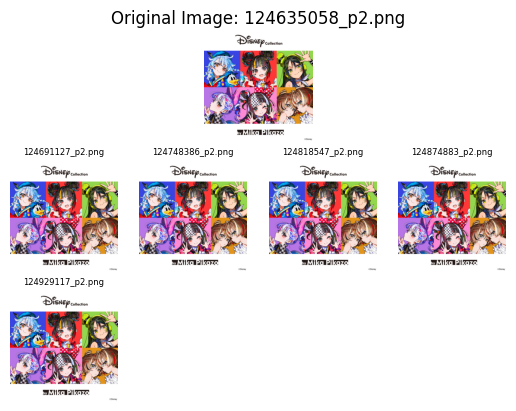

Cluster size = 6


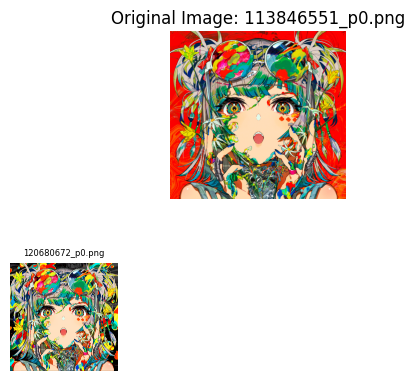

Cluster size = 2


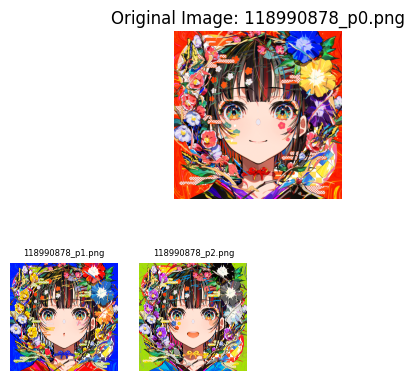

Cluster size = 3


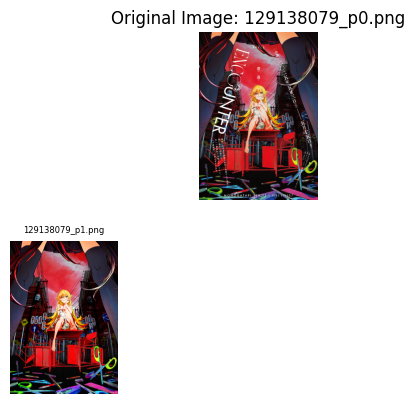

Cluster size = 2


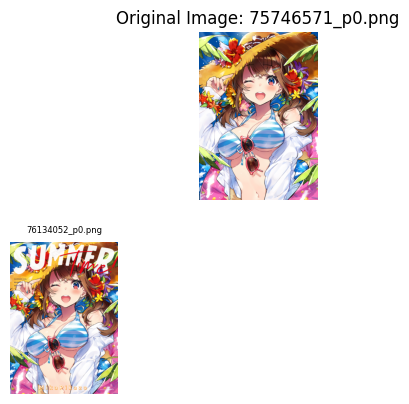

Cluster size = 2


In [10]:
# %% Preview without duplication (only HASH stage shown)
dup_map = merged_dups          # or md5_dup_map
visited = set()
shown   = 0  
Max_shown = 5              

print("\n=== DUPLICATE GROUPS ===")
for root, group in dup_map.items():
    if root in visited:
        continue
    plot_duplicates(str(IMAGE_DIR), dup_map, filename=root)
    print(f"Cluster size = {len(group)+1}")
    visited.update(group); visited.add(root)
    shown += 1
    if shown >= Max_shown:        
        break

In [ ]:
# Move duplicates into per‑cluster folders (keep best original)

def image_resolution(path: Path) -> int:
    """Return pixel count (w*h) without loading full array."""
    with Image.open(path) as im:         # Pillow size :contentReference[oaicite:1]{index=1}
        w, h = im.size
    return w * h

moved_files = []    

for idx, cluster in enumerate(clusters, 1):
    live = [fn for fn in cluster if (IMAGE_DIR / fn).exists()]
    if not live:
        print(f"Cluster {idx:04d} already processed, skip.")
        continue

    best_img = max(
        live,
        key=lambda fn: (
            image_resolution(IMAGE_DIR / fn),
            (IMAGE_DIR / fn).stat().st_size,
        ),
    )

    group_dir = REVIEW_DIR / f"cluster_{idx:04d}"
    group_dir.mkdir(parents=True, exist_ok=True)

    for fn in live:               
        src = IMAGE_DIR / fn
        dst = group_dir / fn
        if fn == best_img:
            shutil.copy2(src, dst)  
        else:
            shutil.move(src, dst)
            moved_files.append(fn)

    print(f"Cluster {idx:04d}: kept {best_img}, moved {len(live)-1} dupes.")

print("All clusters processed; review folders ready.")

Cluster 0001: kept 124635058_p2.png, moved 0 dupes.
Cluster 0002: kept 113846551_p0.png, moved 0 dupes.
Cluster 0003: kept 118990878_p2.png, moved 0 dupes.
Cluster 0004: kept 129138079_p1.png, moved 0 dupes.
Cluster 0005: kept 75746571_p0.png, moved 0 dupes.
All clusters processed; review folders ready.


In [25]:
# Summary
total_checked = len(list(IMAGE_DIR.glob('*'))) + len(moved_files)
print(f"""
======== SUMMARY ========
Images processed : {total_checked}
MD5 duplicates   : {len(byte_dups)}
Hash duplicates  : {len(hash_dups)}
CNN duplicates   : {len(cnn_dups)}
Files moved      : {len(moved_files)}
Meta saved to    : {WORK_DIR}
Dup moved to     : {REVIEW_DIR}
""")


======== SUMMARY ========
Images processed : 475
MD5 duplicates   : 481
Hash duplicates  : 6
CNN duplicates   : 483
Files moved      : 0
Meta saved to    : E:\DeepLearning\Data\Mika-Pikazo_Full\_dedup_meta

